In [1]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import cv2
from collections import Counter


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

In [4]:
focal_length = np.array([1742, 1744])
principle_point = np.array([2000, 1500])
radial_distortion = np.array([-0.251, 0.0689])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)

In [5]:
cv2.Rodrigues(np.array([[0.,0,-1],[1,0,0],[0,-1,0]]))[0]

array([[-1.20919958],
       [-1.20919958],
       [ 1.20919958]])

In [6]:
camera_rotations = np.array([
    [0, 0, 0],         # facing +z
    [0, +np.pi, 0],    # facing -z
    [0, -np.pi/2, 0],  # facing +x
    [0, +np.pi/2, 0],  # facing -x
    [+np.pi/2, 0, 0],  # facing +y
    [-2*np.pi/np.sqrt(27), -2*np.pi/np.sqrt(27), 2*np.pi/np.sqrt(27)]]) # facing -y, and rotated 90 degrees about camera axis
camera_radial_position = 400
camera_halfz_position = 300
camera_translations = np.array([ # rotation already applied so just shift in z-dir to place camera at wall
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_halfz_position],
    [0., 0., camera_halfz_position]])

In [7]:
pmt_locations = fit.read_3d_feature_locations("parameters/IWCD_PMT_locations.txt", delimiter=" ")
mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>290 else np.array((0,1,0)) if v[1]<-290 else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2) for k, v in mpmt_locations.items()}
led_ring_radius = 24.
led_count = 4
led_positions_12 = {}
for k, v in mpmt_locations.items():
    for i in range(led_count):
        if abs(v[1])>290:
            led_positions_12[k+'_'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
        else:
            phi = np.arctan2(v[2], v[0])
            led_positions_12[k+'_'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])

In [8]:
nimages = len(camera_translations)
nfeatures = len(led_positions_12)

In [9]:
image_feature_locations = {
    i : {list(led_positions_12.keys())[f]:v for f, v in enumerate(
        cv2.projectPoints(np.array(list(led_positions_12.values())), r, t,
                          camera_matrix, distortion)[0].reshape((-1,2)))
         if v[0] > 0 and v[0] < 4000 and v[1] > 0 and v[1] < 3000}
    for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}

<IPython.core.display.Javascript object>


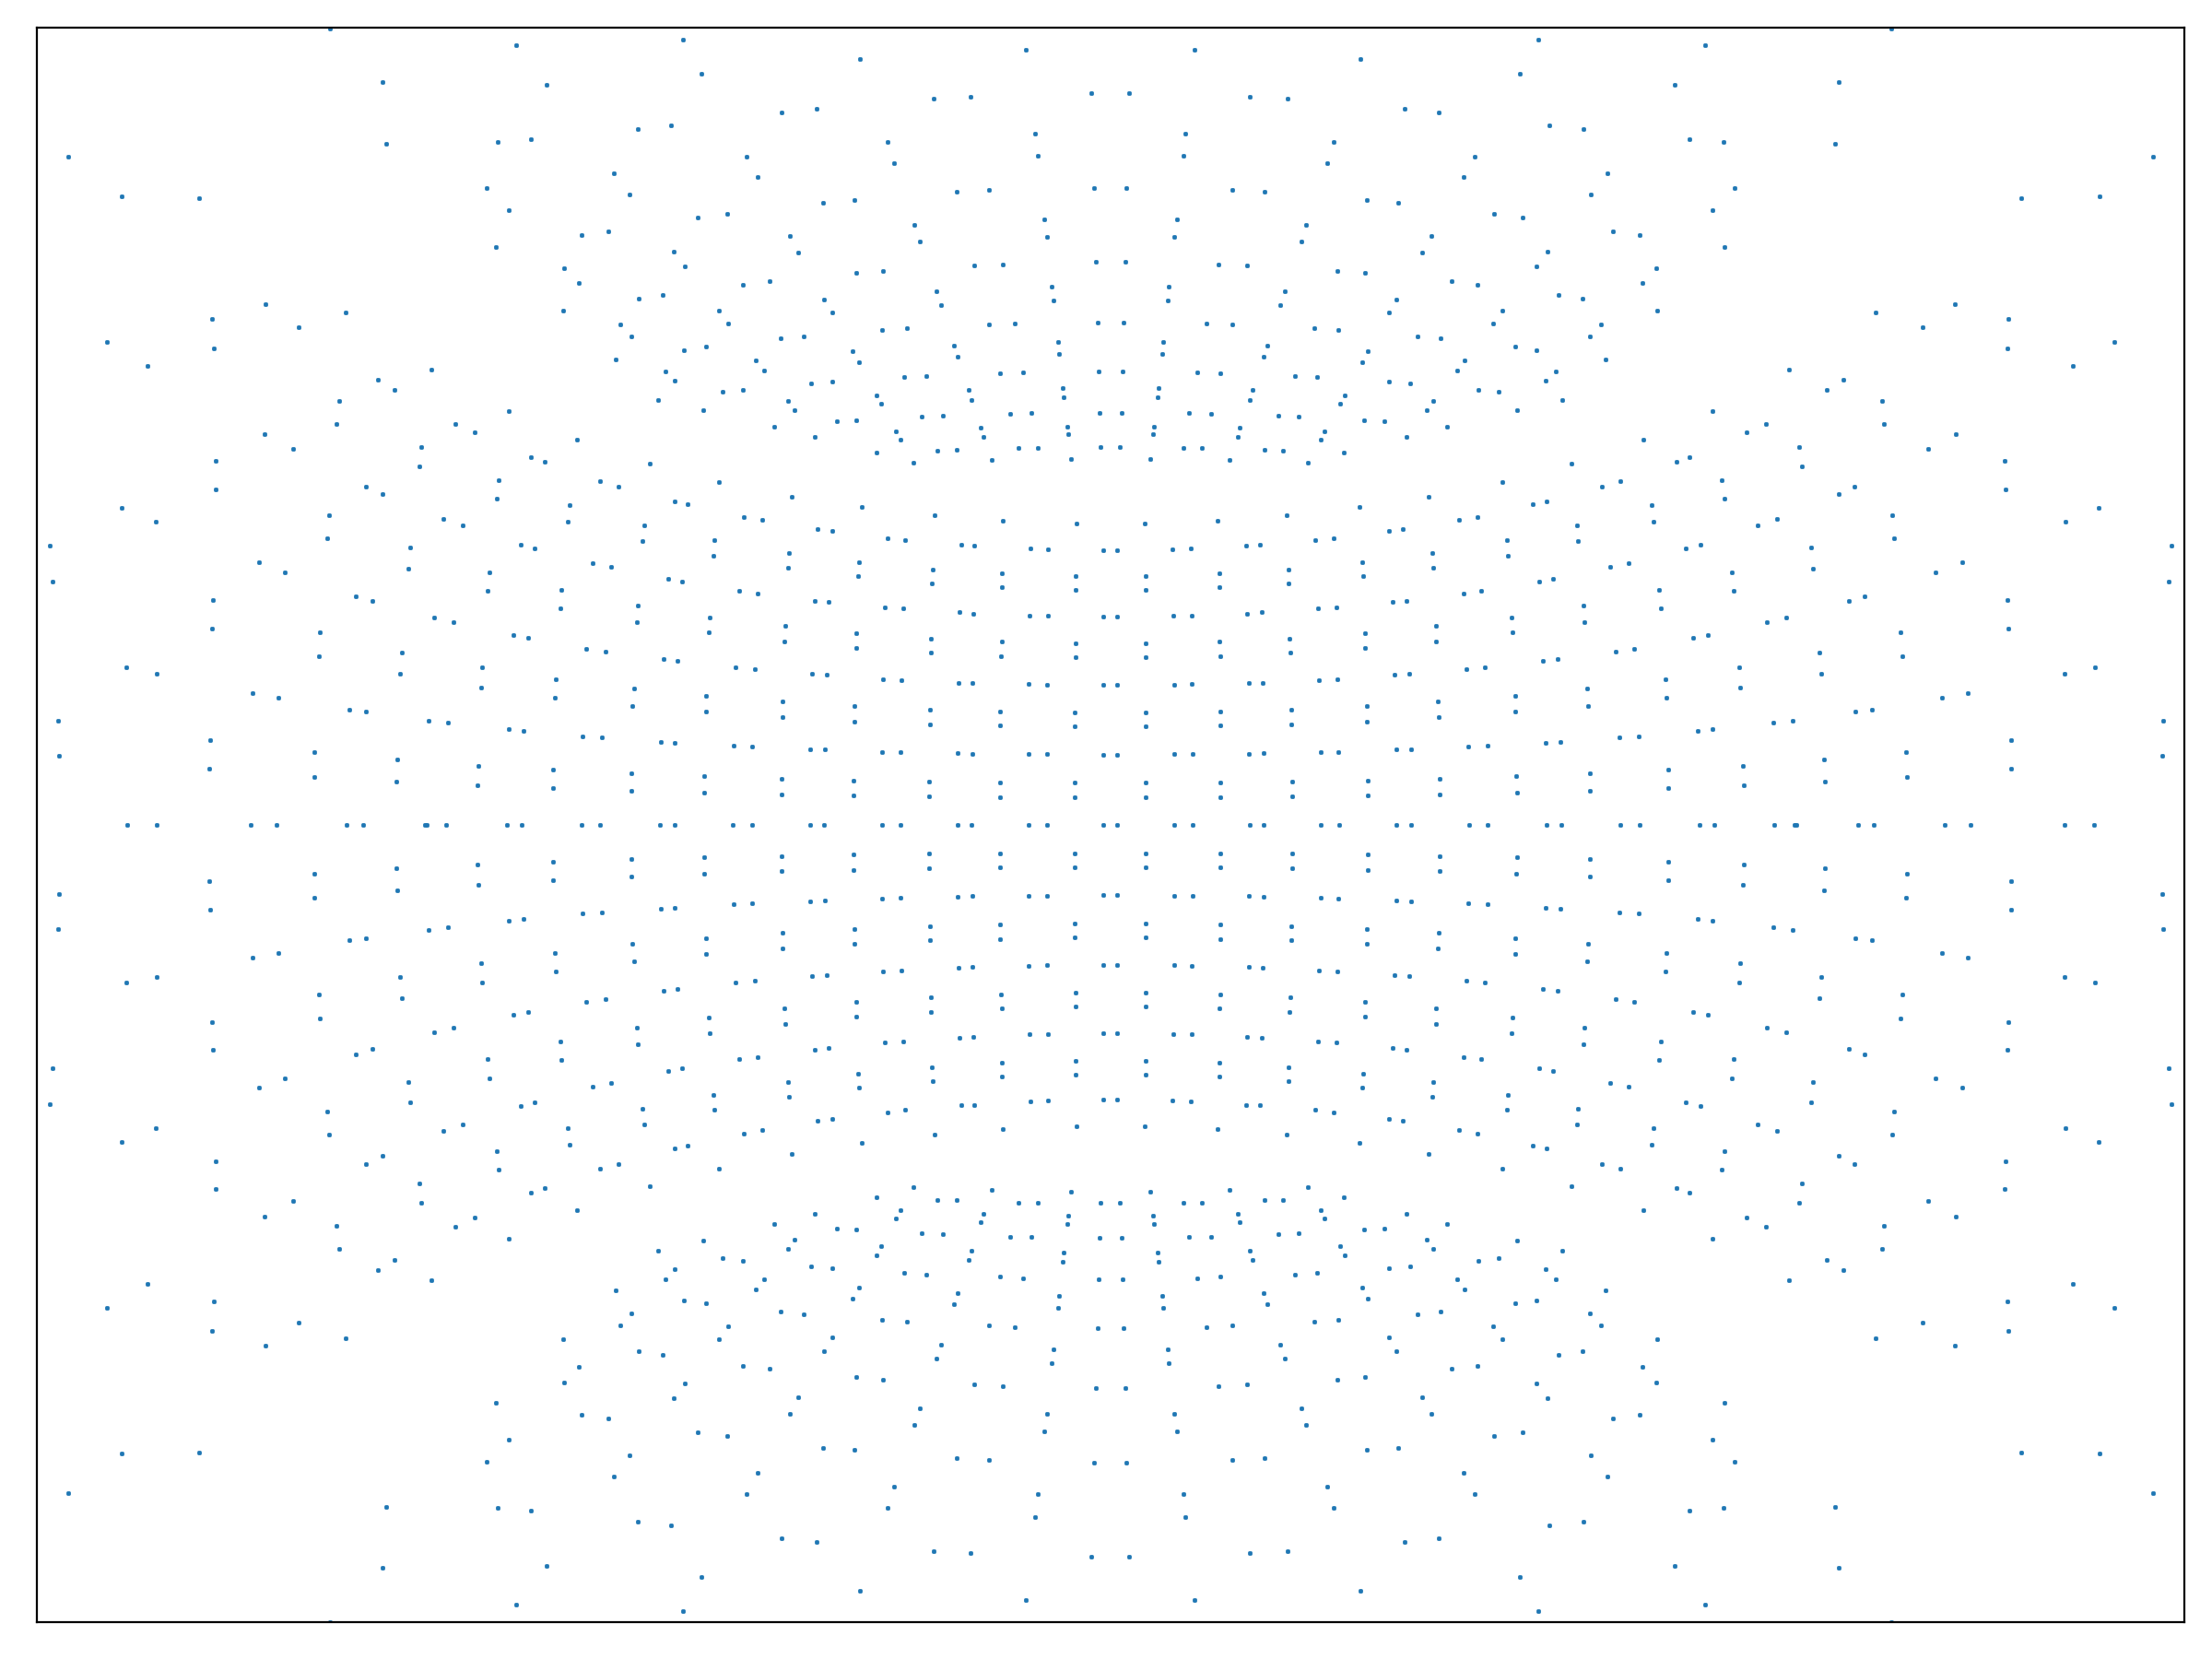

<IPython.core.display.Javascript object>


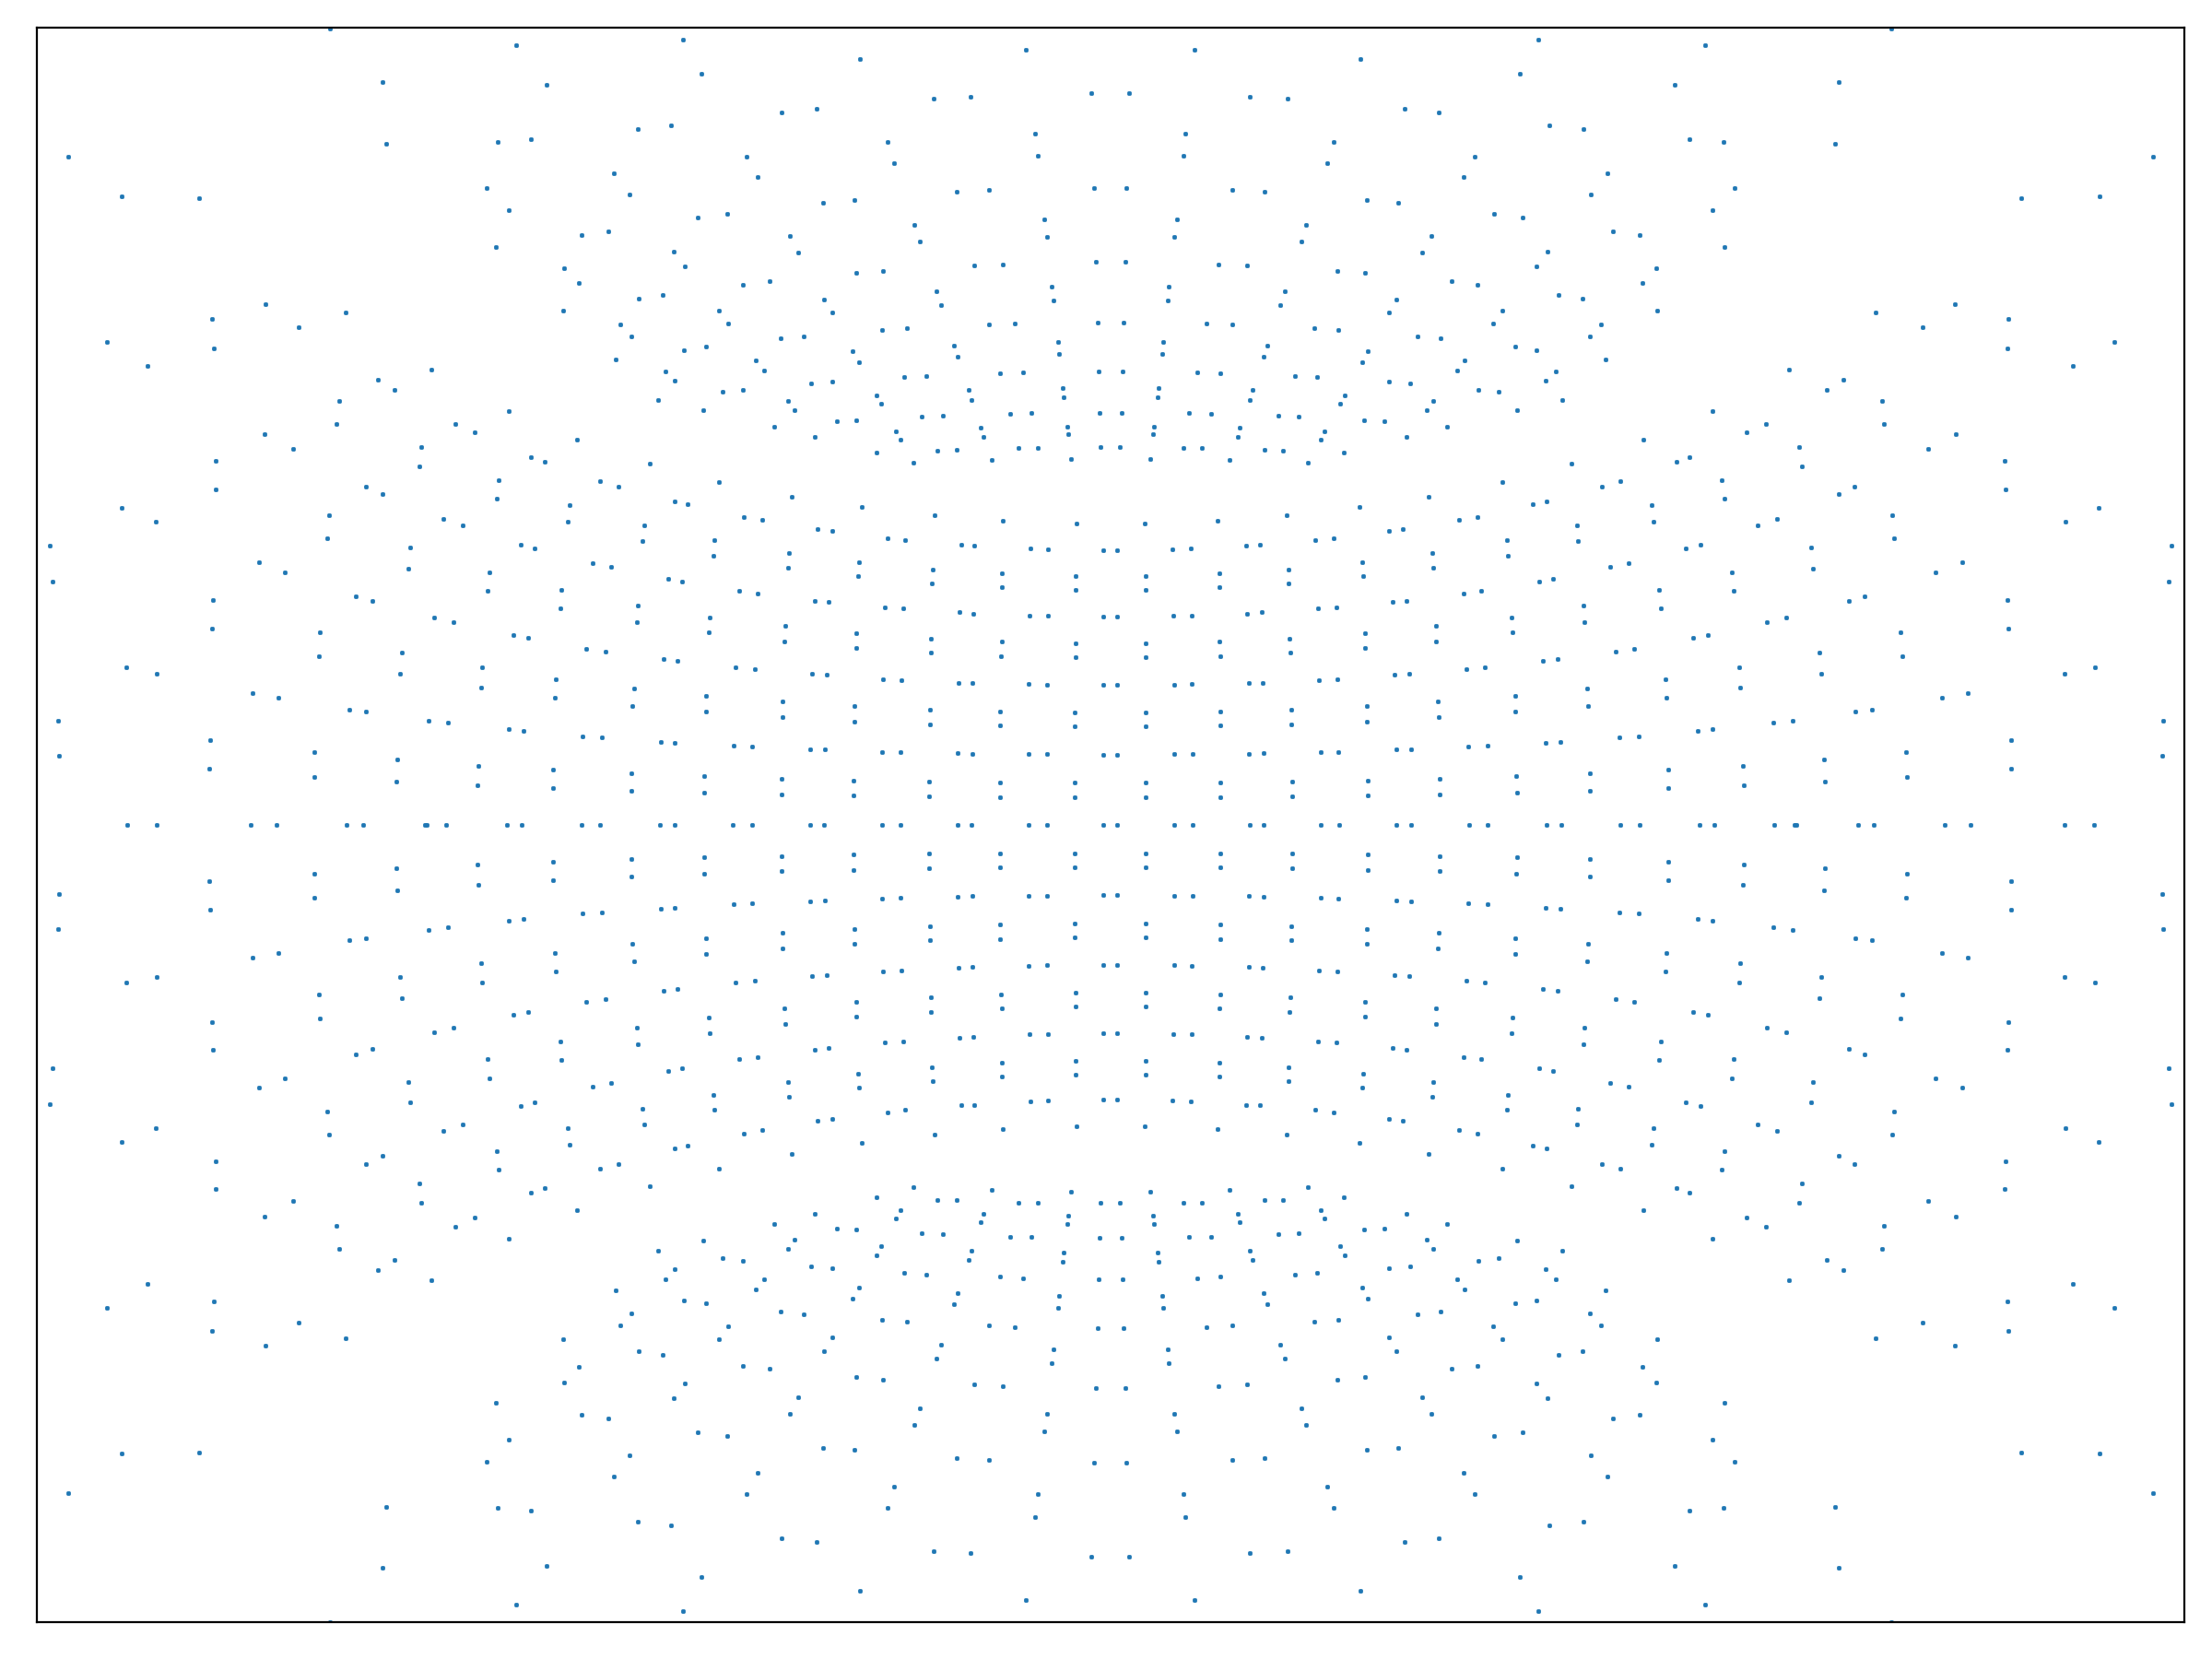

<IPython.core.display.Javascript object>


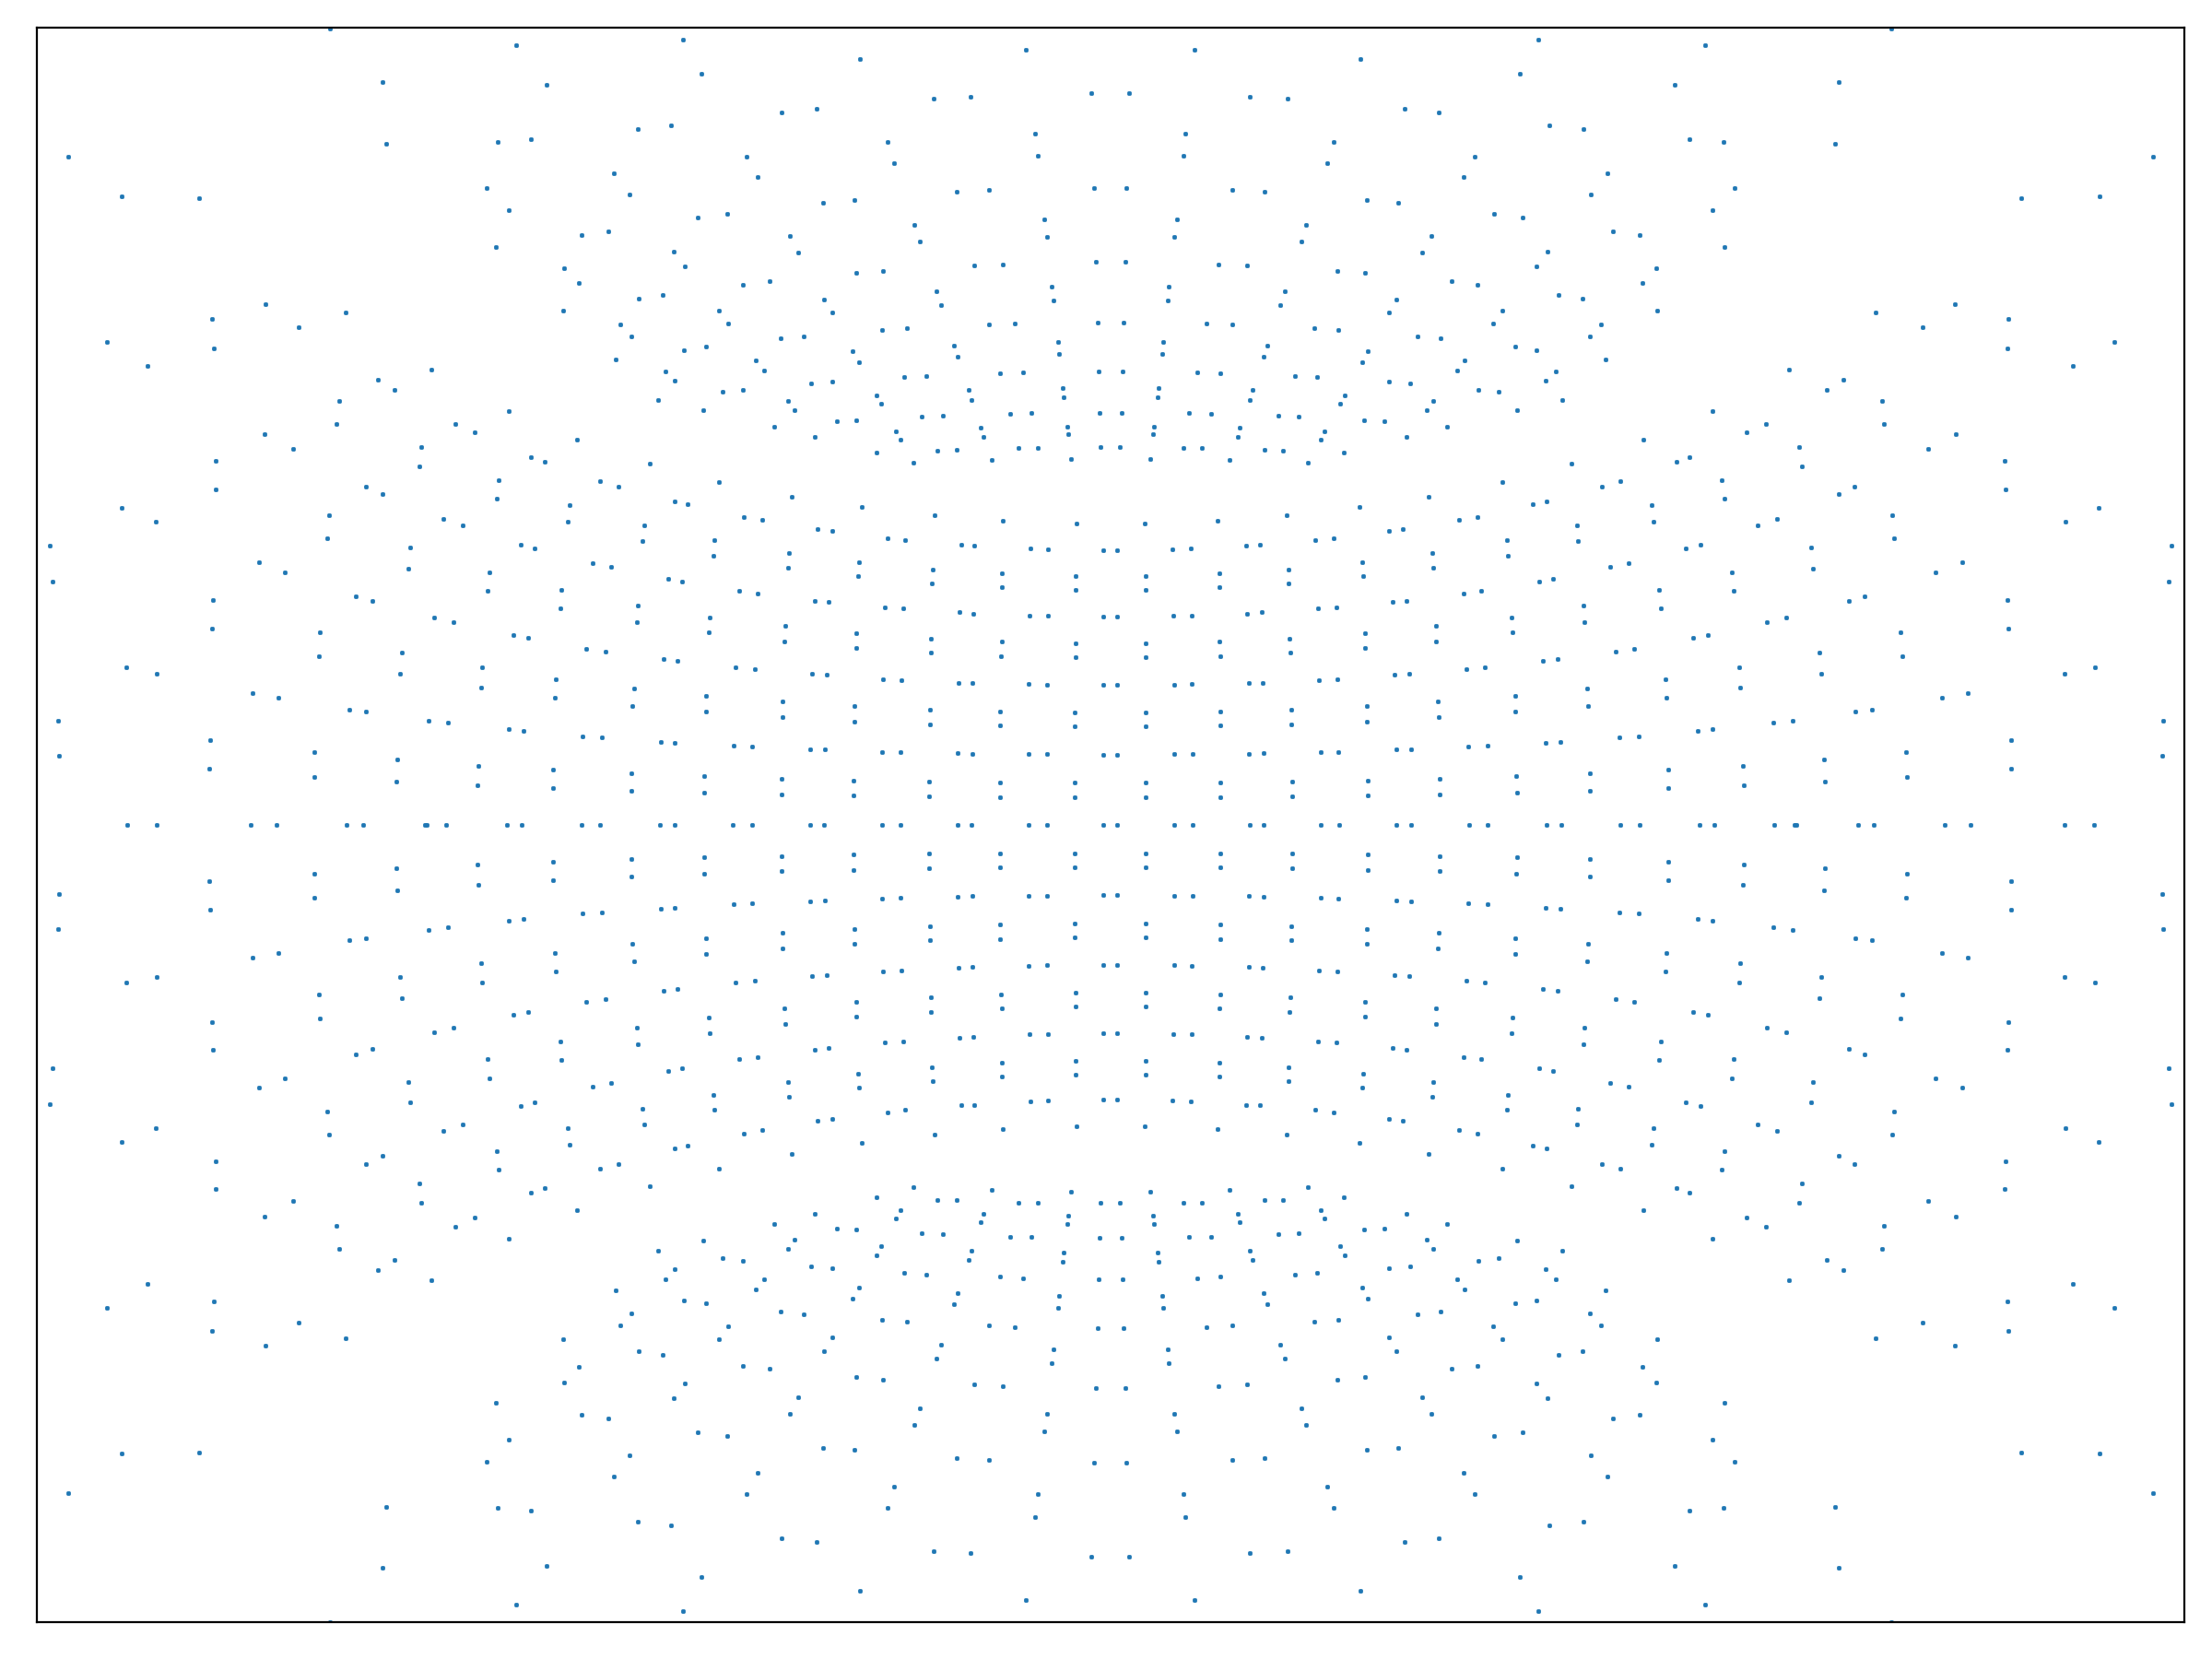

<IPython.core.display.Javascript object>


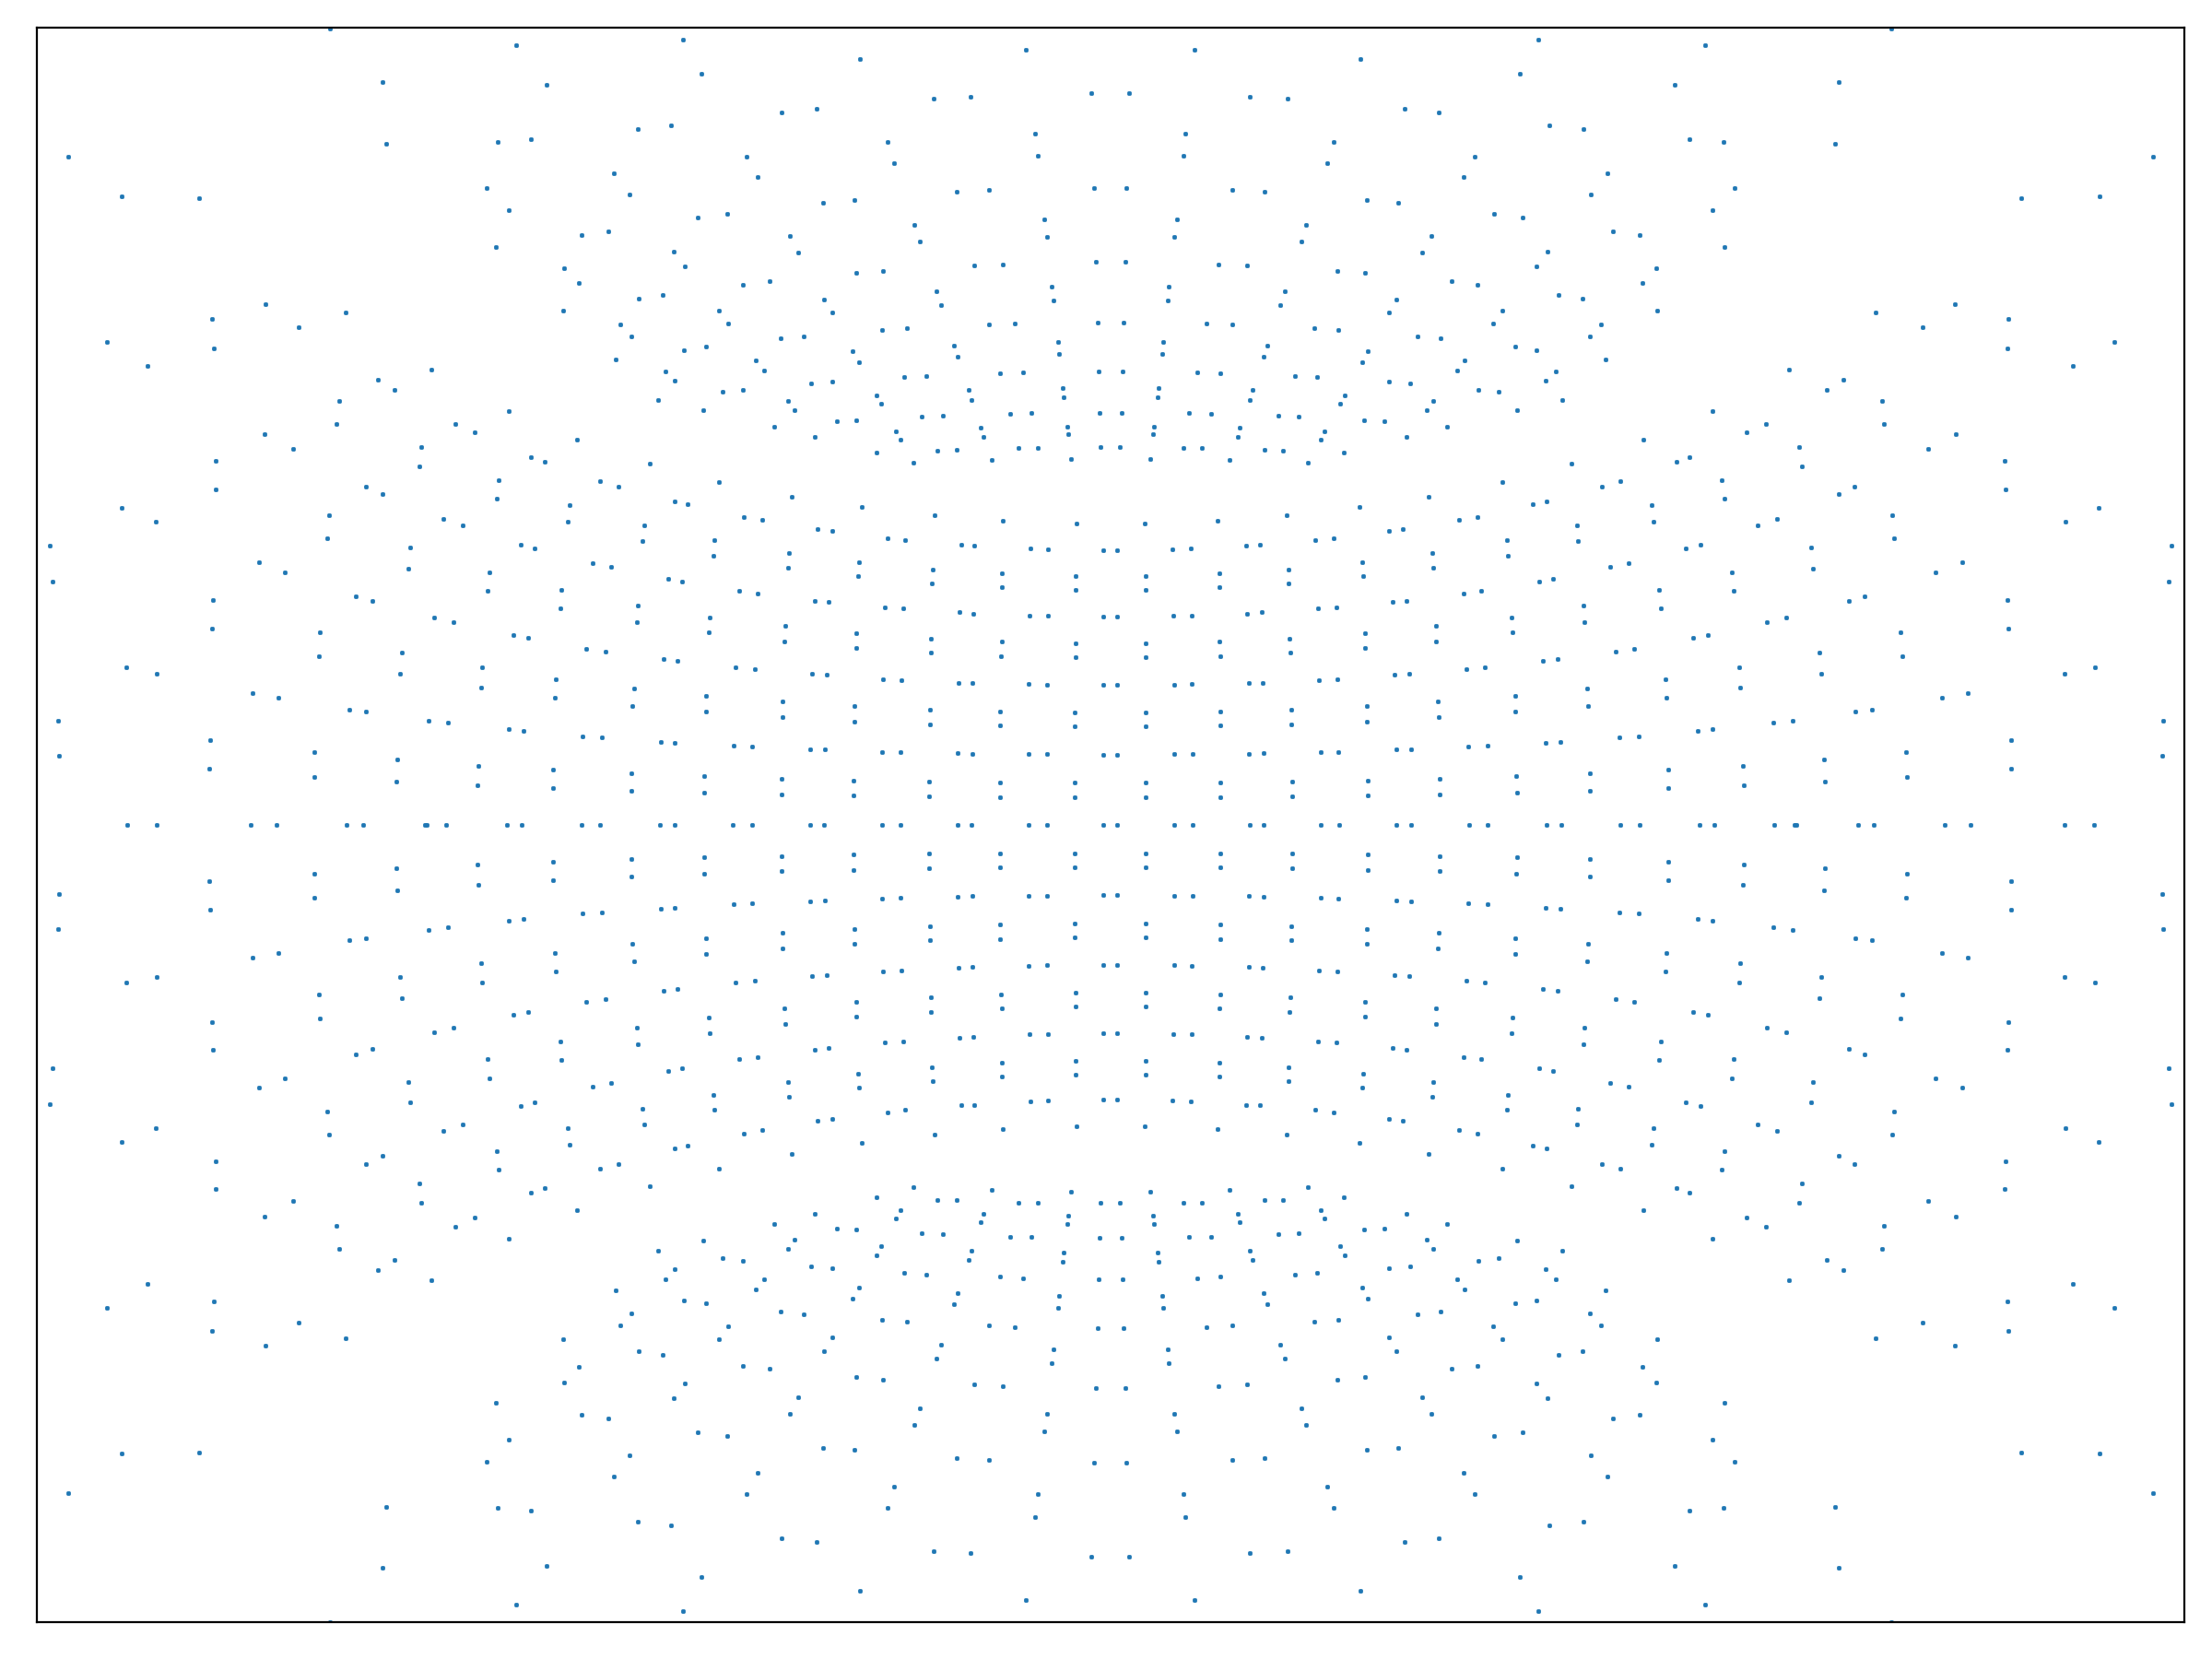

<IPython.core.display.Javascript object>


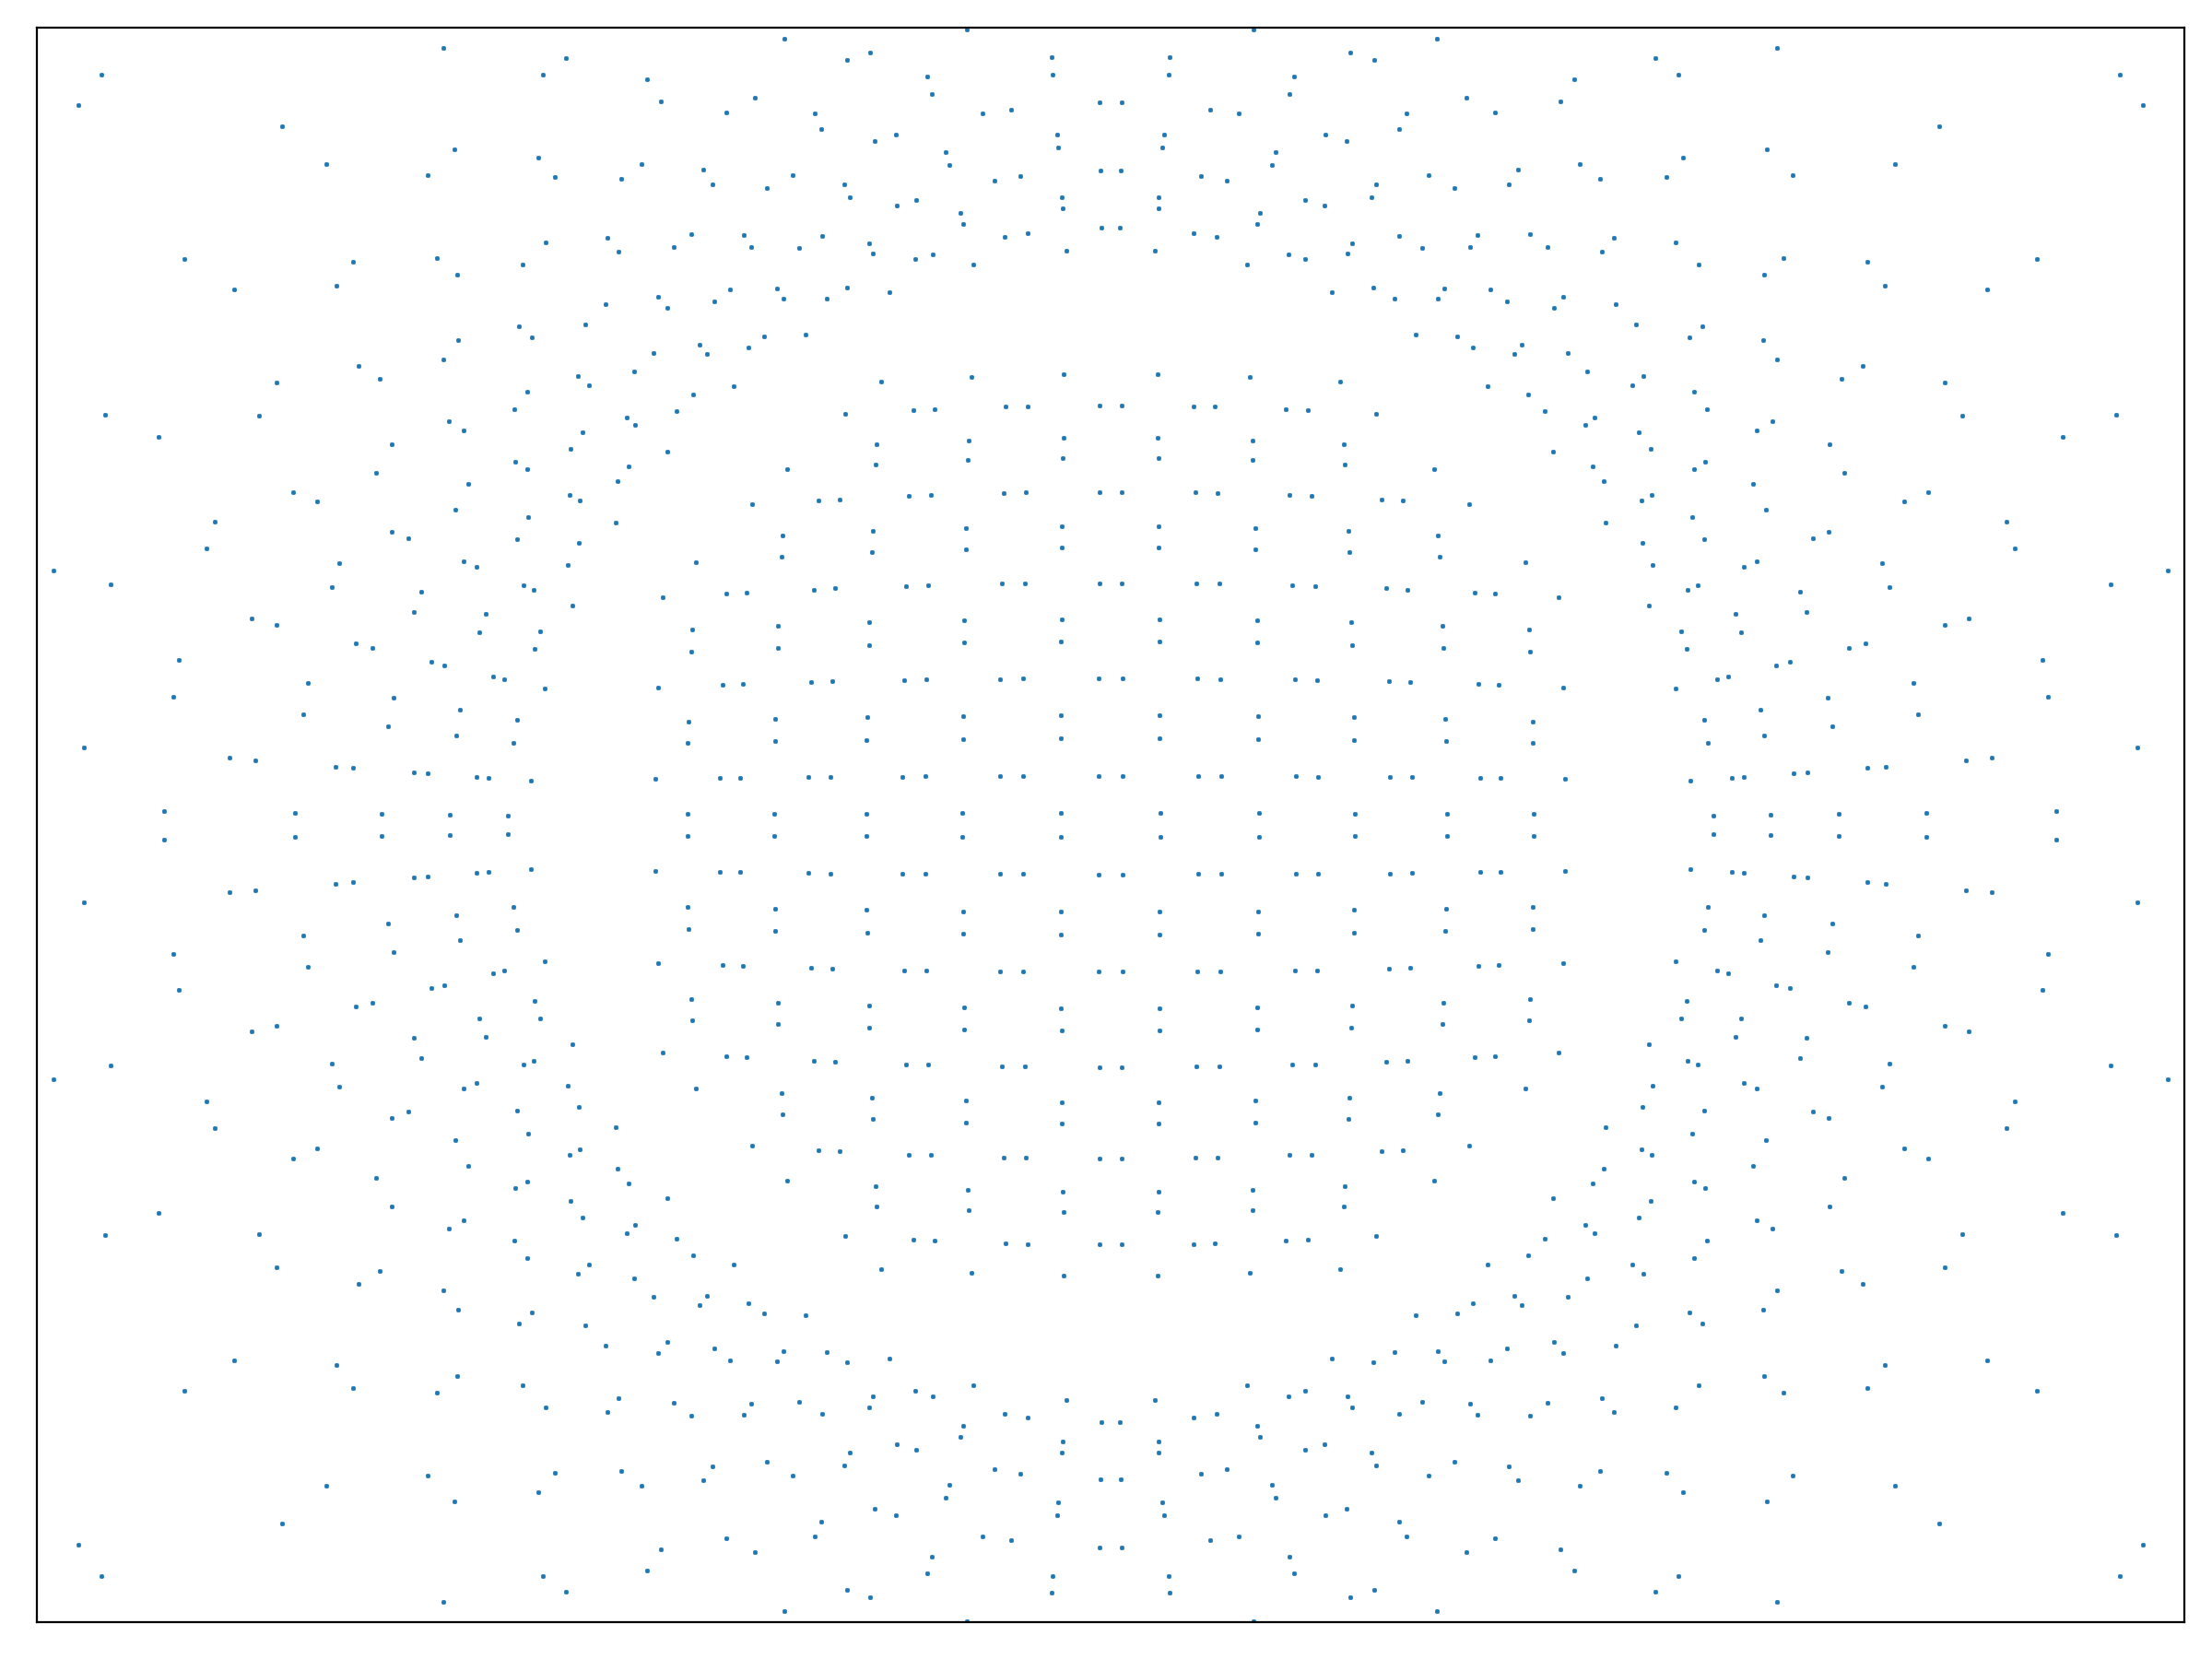

<IPython.core.display.Javascript object>


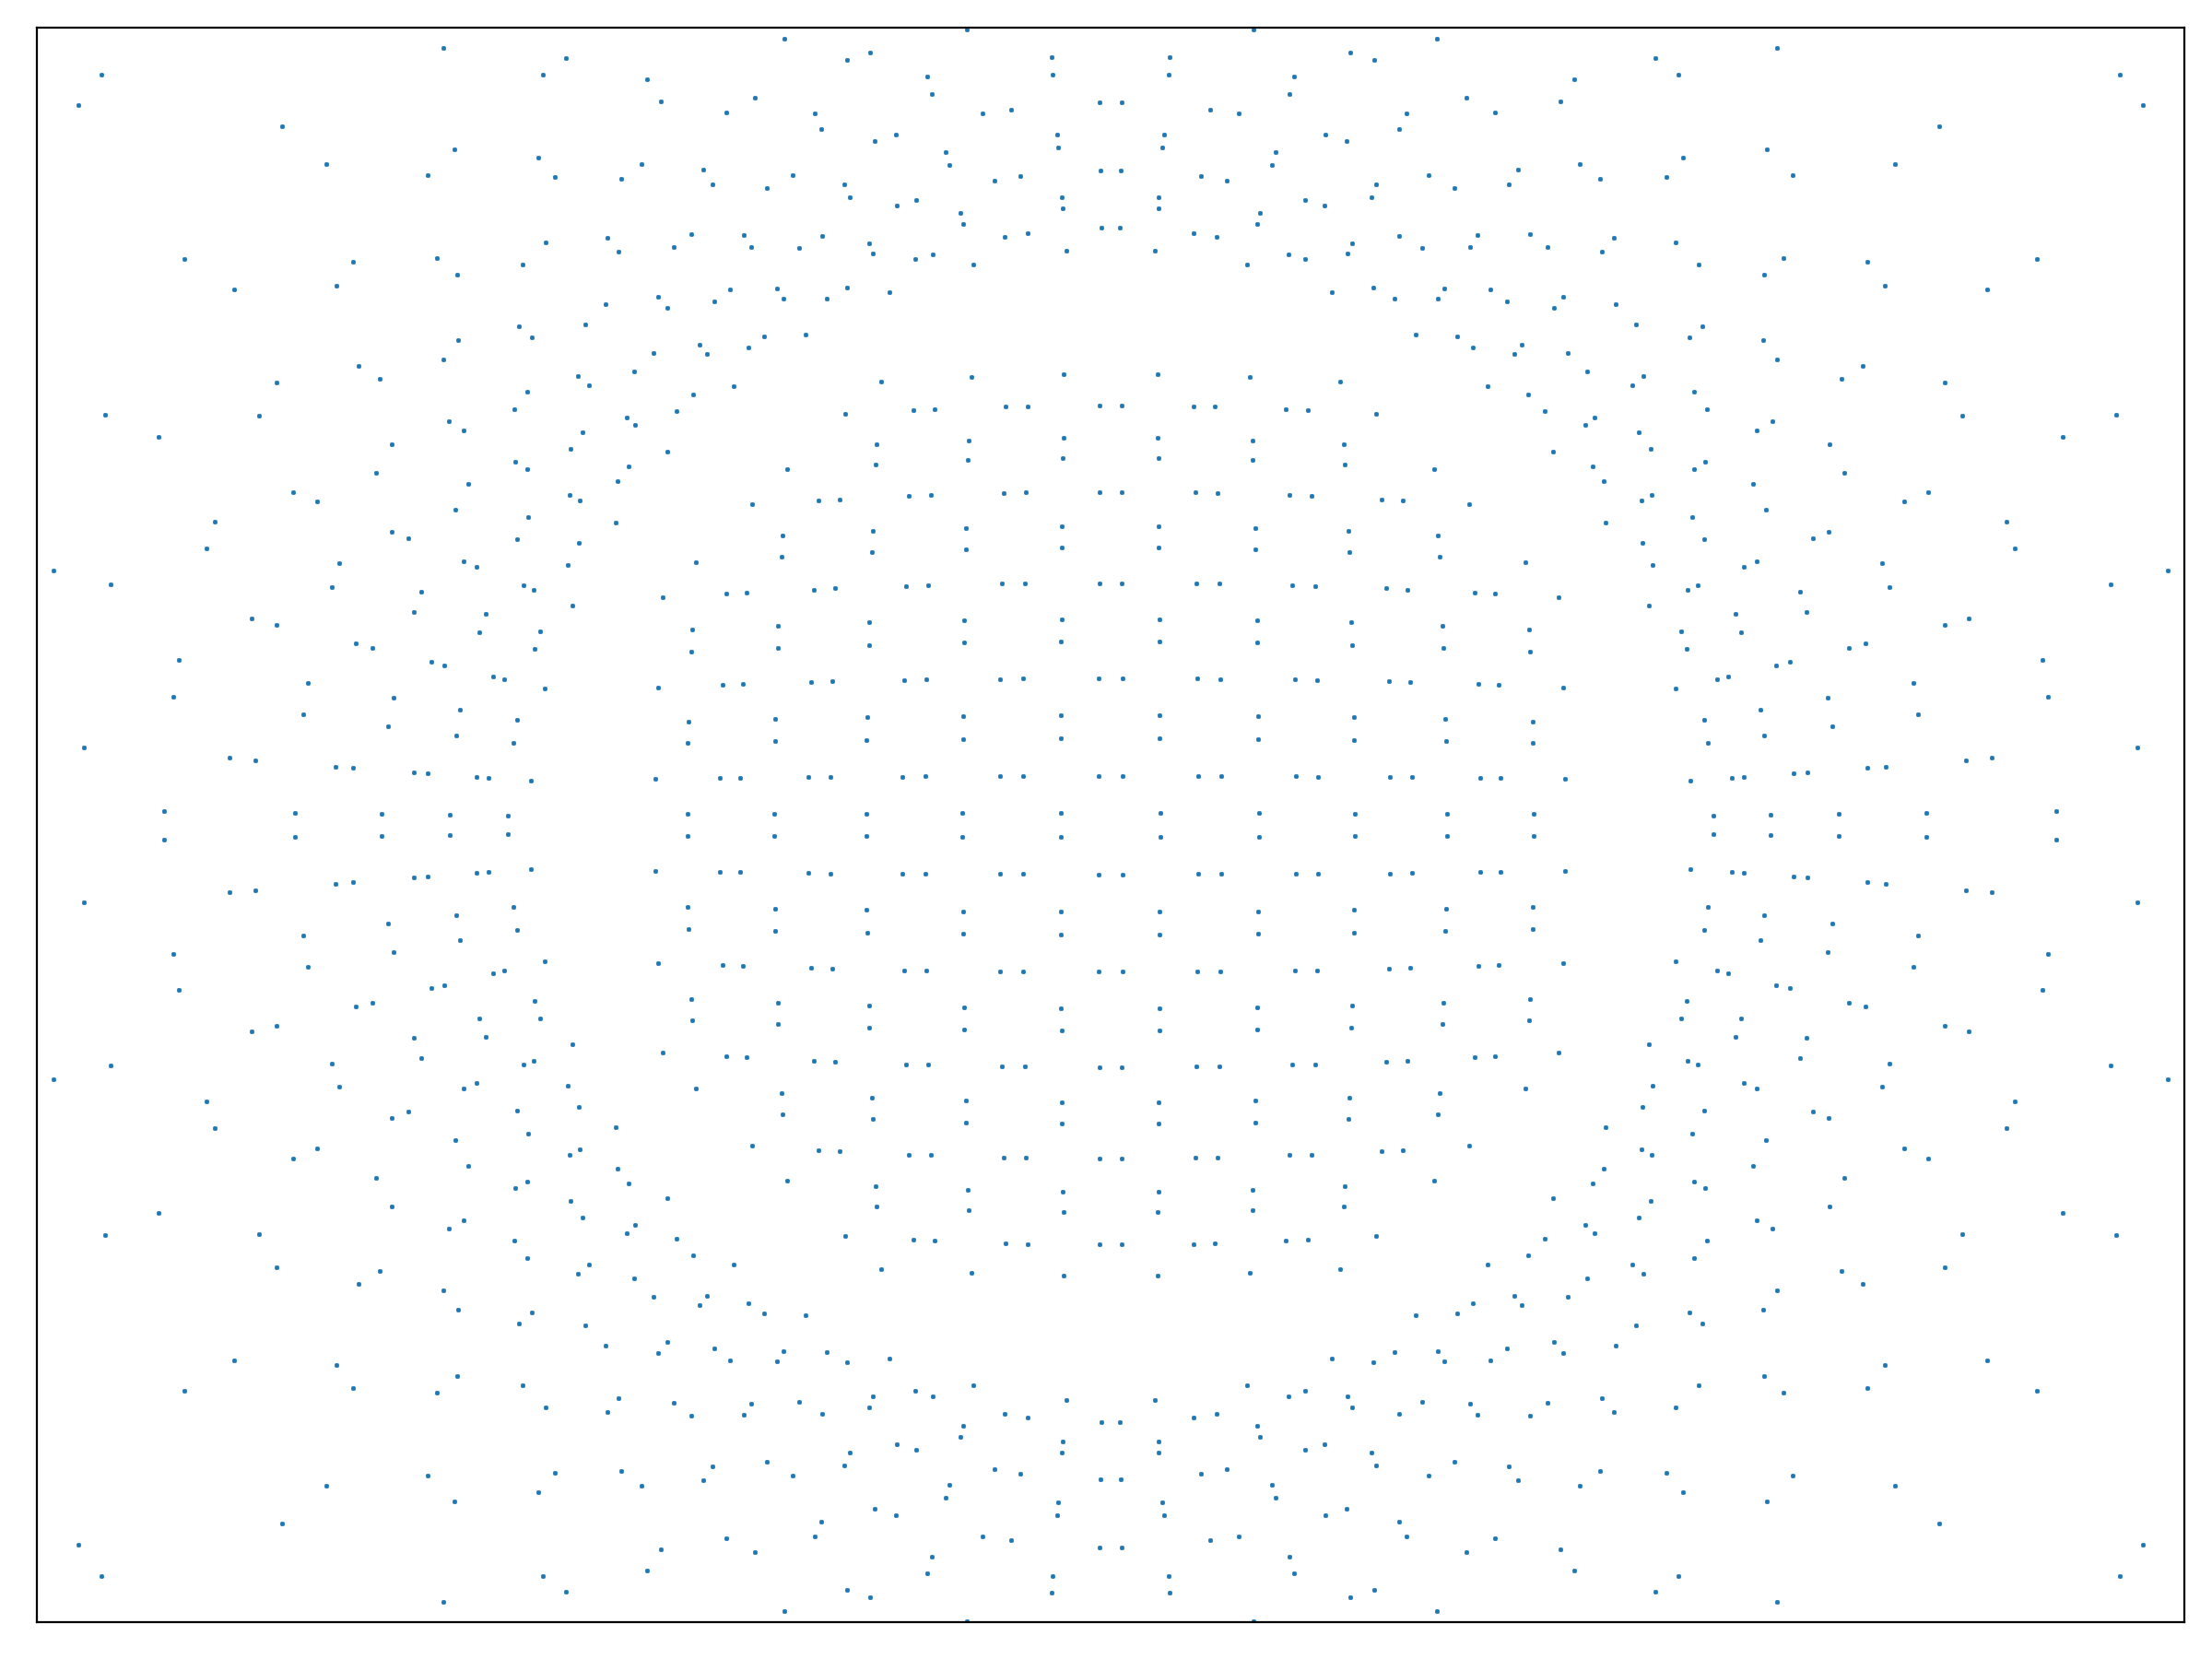

In [10]:
for i in image_feature_locations.values():
    fig, ax = plt.subplots(figsize=(12,9))
    coords = np.rint(np.stack(list(i.values())))
#    pixels = [matplotlib.patches.Rectangle((c[0],-c[1]), 1, 1) for c in coords]
#    collection = matplotlib.collections.PatchCollection(pixels, facecolor='black')
#    ax.add_collection(collection)
    ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
    ax.set_xlim((0, 4000))
    ax.set_ylim((-3000, 0))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    fig.tight_layout()
#    for t, f in i.items():
#        ax.text(f[0], -f[1], t, size=4, zorder=4, color='k')

In [11]:
pixel_error = 0.5
for k, i in image_feature_locations.items():
    for j, f in i.items():
        image_feature_locations[k][j] = np.random.normal(f, pixel_error)

In [12]:
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
Counter(feature_counts.values())

Counter({4: 1184, 3: 816, 5: 144})

In [13]:
fitter = fit.PhotogrammetryFitter(image_feature_locations, led_positions_12,
                                  focal_length, principle_point, radial_distortion)

In [14]:
reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()

image 0 reprojection errors:    average: 0.6843847498732483    max: 27.679377119576476
image 1 reprojection errors:    average: 0.7037318266443167    max: 29.076415353968155
image 2 reprojection errors:    average: 0.6926236925026025    max: 29.070539273201433
image 3 reprojection errors:    average: 0.6700933891657425    max: 20.934341494468555
image 4 reprojection errors:    average: 1.4346134534584154    max: 6.273387163869659
image 5 reprojection errors:    average: 0.9402489437281089    max: 4.753456756070815


In [15]:
reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(
    reco_cam_rotations, reco_cam_translations)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2786e+03                                    3.03e+06    
       1              4         6.1661e+03      1.13e+02       1.18e+03       4.26e+06    
       2              5         1.7657e+03      4.40e+03       2.95e+02       1.60e+06    
       3              7         1.1973e+03      5.68e+02       1.48e+02       1.74e+05    
       4              9         1.1880e+03      9.29e+00       7.38e+01       3.01e+04    
       5             11         1.1878e+03      1.32e-01       3.69e+01       1.88e+04    
       6             12         1.1877e+03      1.08e-01       3.69e+01       1.17e+04    
       7             14         1.1877e+03      2.24e-02       1.85e+01       3.05e+03    
       8             15         1.1877e+03      4.45e-03       1.85e+01       4.16e+03    
       9             17         1.1877e+03      3.98e-03       4.61e+00       1.77e+02    

In [16]:
errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(
    led_positions_12, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 0.18817261036816207
max reconstruction error: 0.7885093981215335


In [17]:
reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

In [18]:
print(cam_positions_transformed)
print(reco_cam_translations)
print(camera_translations)

[[-7.93062681e-03 -8.10833215e-04 -3.99989630e+02]
 [ 2.76803485e-02  4.50289806e-03  4.00014242e+02]
 [-4.00006997e+02  2.81512058e-03 -3.50441526e-02]
 [ 3.99996991e+02  1.44267205e-02 -1.67547907e-02]
 [-4.19243288e-02 -2.99986813e+02  2.26857537e-02]
 [-1.06292123e-02  3.00012740e+02  1.22563887e-02]]
[[ -4.48287327 -11.3224371  380.22656874]
 [  4.4963403  -11.3228782  419.52704879]
 [ 19.62509802 -11.32681736 395.39514745]
 [-19.63221694 -11.33082118 404.35685211]
 [ -4.45611115  19.64958437 288.56995042]
 [ 19.64376709  -4.48328811 311.24253288]]
[[  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 300.]
 [  0.   0. 300.]]


<IPython.core.display.Javascript object>


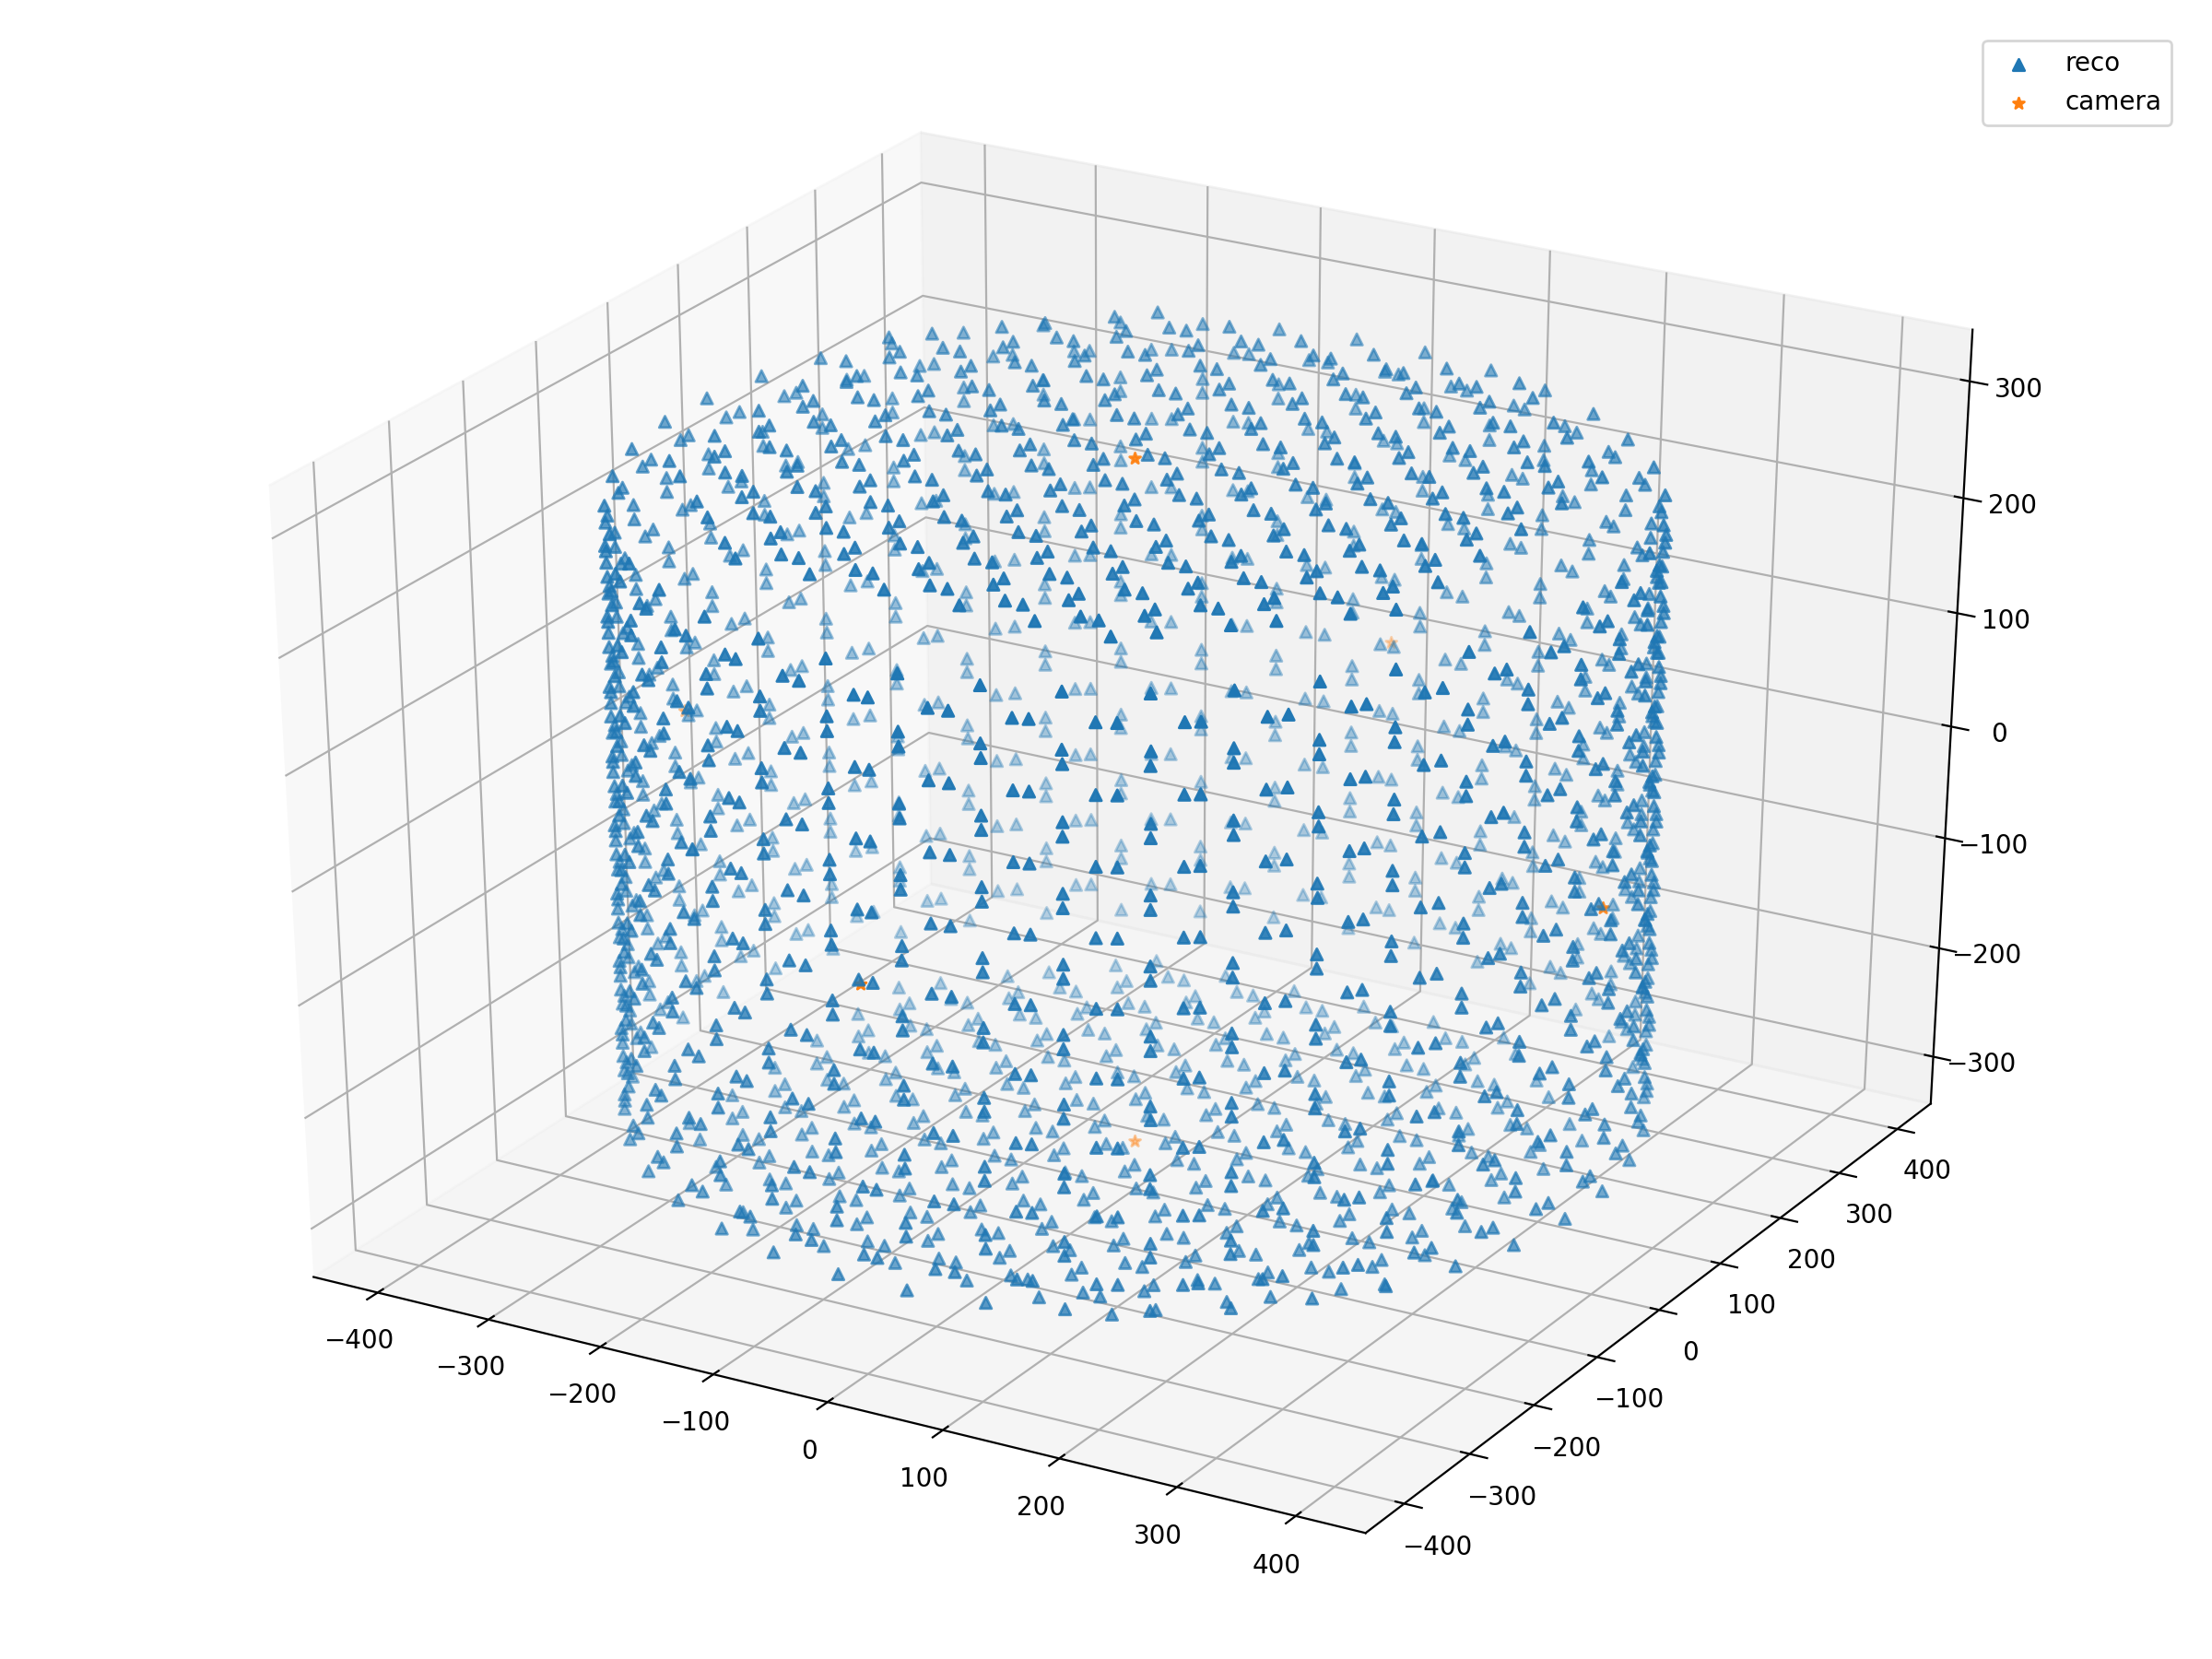

In [19]:
#true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,2], reco_transformed[:,1], marker='^', label="reco")
#ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='o', label="true")
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(true_array[i,0], true_array[i,1], true_array[i,2], f, size=4, zorder=1, color='k') 
ax.scatter(cam_positions_transformed[:,0], cam_positions_transformed[:,2], cam_positions_transformed[:,1],
           marker='*', label="camera")
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


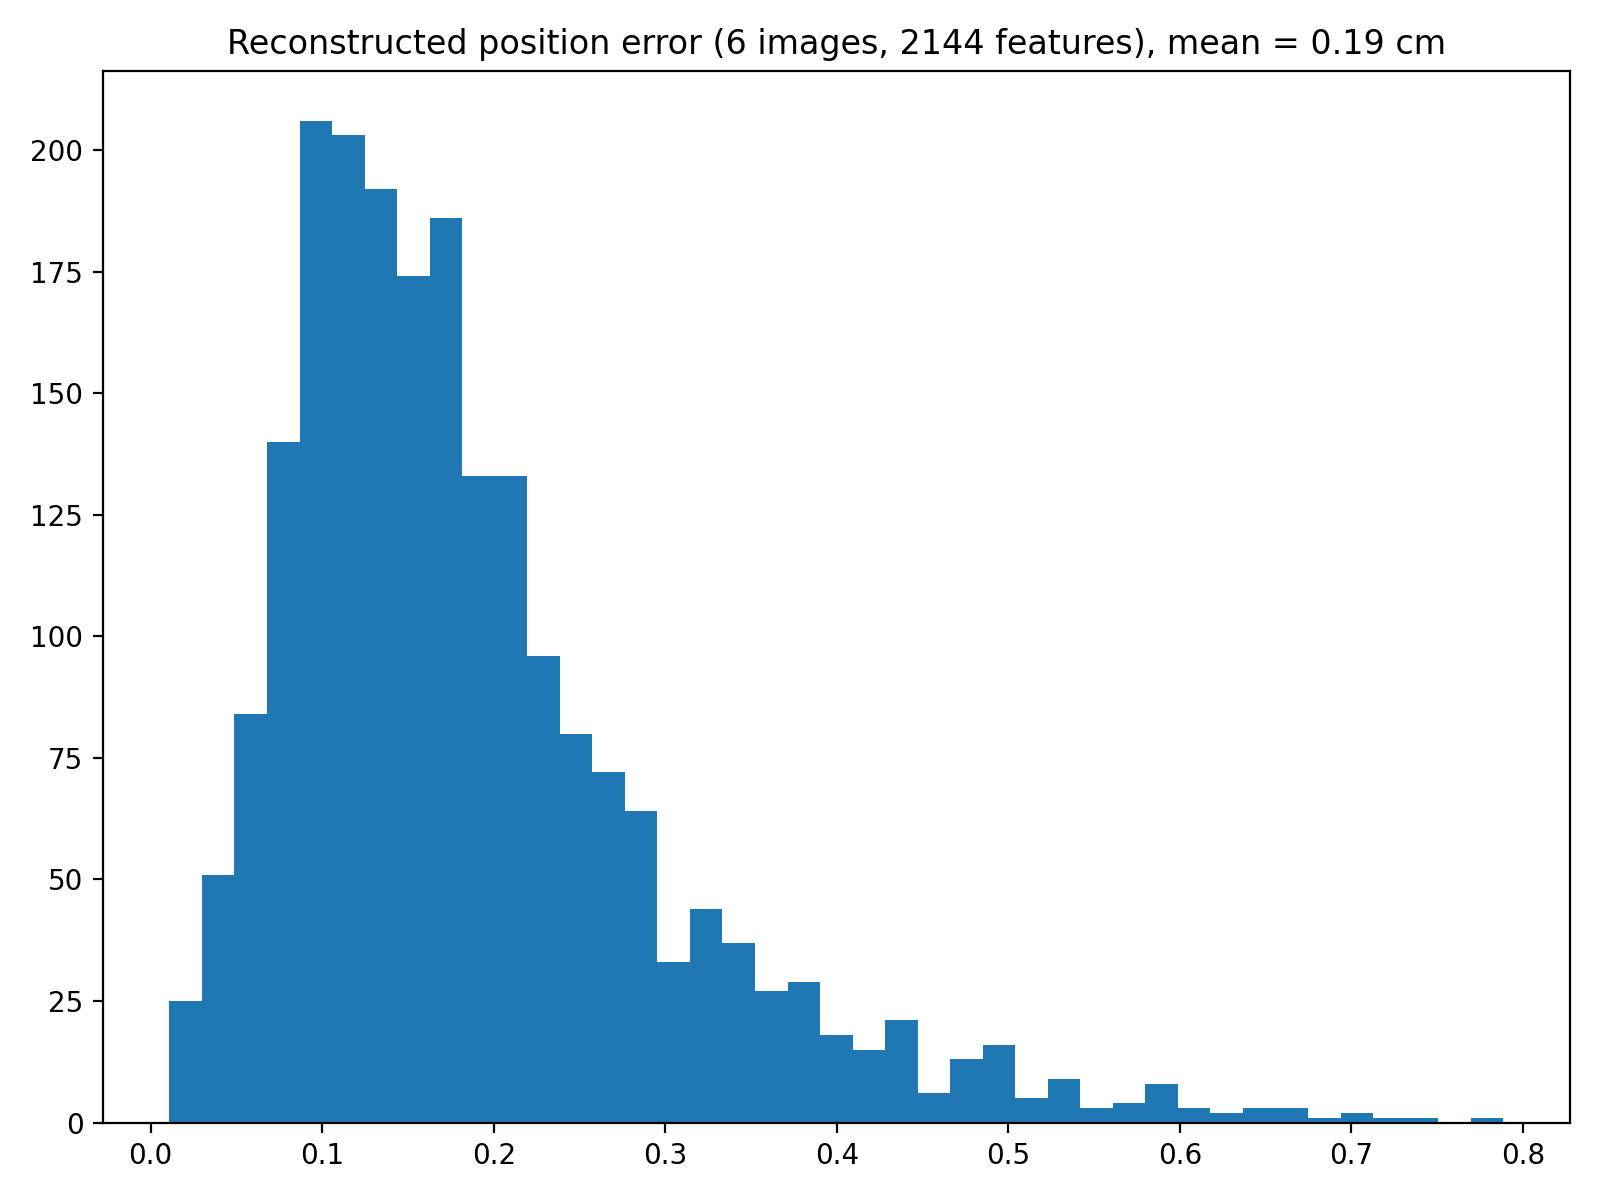

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position error ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()